# Topic Model & Subject Headings


Sources:

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

Kapadia, Shashank, "[Topic Modeling in Python: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)," <i>towards data science</i>, Accessed 10/09/2020.

ALollz, "[How to calculate p-values for pairwise correlation of columns in Pandas?](https://stackoverflow.com/questions/52741236/how-to-calculate-p-values-for-pairwise-correlation-of-columns-in-pandas)," <i>StackOverflow</i>, Accessed 10/13/2020.

In [1]:
# Import necessary libraries.
import re, nltk, warnings, csv, sys, os, pickle
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain
from scipy import stats

# Import NLTK packages.
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Import sklearn packages.
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import LDA visualizer.
import pyLDAvis, pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# Import and append stopwords.
stop_words = stopwords.words("english")
stop_words.append('mr')

# Ignore warnings related to deprecated functions.
warnings.simplefilter("ignore", DeprecationWarning)

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/Data/"

# Read in file; select columns; drop rows with NA values (entries without a named person).
df = pd.read_csv(abs_dir + 'Output/ParsedXML/JQA_Subjects-dataframe.txt',
                 sep = '\t') \
    .dropna()

df.head()

,file,entry,date,subject,text
0,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-01,1817-10-01,"Adams Family Residences,Commerce",1. IV:30. Wednesday. Wrote a Letter to J. L. S...
1,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-02,1817-10-02,"Foreign Relations,Health and Illness,South Ame...",2. IV: Continued drafting instructions for Rus...
2,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-03,1817-10-03,"Adams Family Residences,Privateering,Recreatio...",3. IV: I had visits this morning from Mr Levet...
3,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-04,1817-10-04,"Commerce,Foreign Relations,Health and Illness",4. IV: I waked before three and had afterwards...
4,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-05,1817-10-05,Adams Family Residences,5. V: The Ladies went this morning to St. John...


## Clean Data & Prepare for Topic Modeling

In [2]:
%%time

# Unnest subject headings.
df['subject'] = df['subject'].str.split(',')
df = df.explode('subject')

# Lowercase text field
df['text'] = df['text'].str.lower()

# Tokenize text field.
df['text'] = df['text'].apply(word_tokenize)

# Lemmatize and stem text field.
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english", ignore_stopwords = True)

def lemma_and_stem(list_of_words):
    return [stemmer.stem(lemmatizer.lemmatize(w)) for w in list_of_words if w not in stop_words]

df['text'] = df['text'].apply(lemma_and_stem)

# Convert list of words to string for LDA model.
df['text'] = df['text'].apply(' '.join)

print ('Number of unique subject headings:', len(df['subject'].unique()), '\n')

df.head()

Number of unique subject headings: 118 

CPU times: user 53.6 s, sys: 469 ms, total: 54.1 s
Wall time: 54.7 s


,file,entry,date,subject,text
0,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-01,1817-10-01,Adams Family Residences,1. iv:30. wednesday . wrote letter j. l. sulli...
0,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-01,1817-10-01,Commerce,1. iv:30. wednesday . wrote letter j. l. sulli...
1,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-02,1817-10-02,Foreign Relations,2. iv : continu draft instruct rush . subject ...
1,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-02,1817-10-02,Health and Illness,2. iv : continu draft instruct rush . subject ...
1,JQADiaries-v30-1817-10-p260.xml,jqadiaries-v30-1817-10-02,1817-10-02,South American Wars of Independence,2. iv : continu draft instruct rush . subject ...


#### Average Document Length

Topic modeling is sensitive to document length. Longer documents, which discuss multiple topics, might water down the end results. It might be good to shorten and normalize document lengths.

How will multiple subject headings relate to splitting entries? Will splitting entries wash down/skew results of topic correlation?

CPU times: user 242 ms, sys: 6.16 ms, total: 248 ms
Wall time: 253 ms


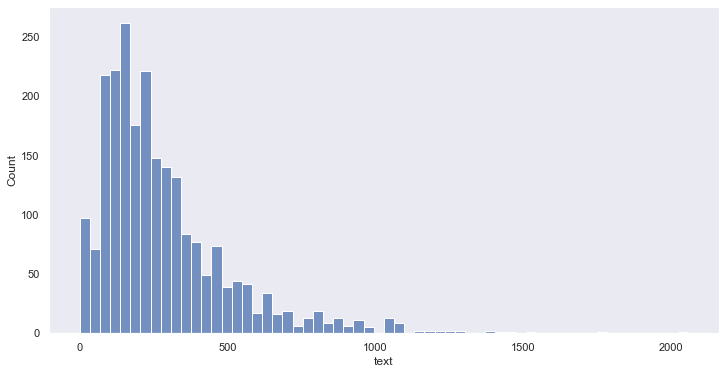

In [3]:
%%time

# Drop duplicate texts (created from unnested subject headings) & count words.
doc_len = df['text'].str.split(' ').str.len() \
    .reset_index() \
    .drop_duplicates()

# Round word count.
doc_len = np.around(doc_len['text'], decimals = -1)

doc_len = pd.DataFrame(doc_len)

# Plot graph.
sns.set(rc = {"figure.figsize": (12, 6)})
sns.set_style("dark")
ax = sns.histplot(doc_len['text'])

## Train Topic Model

>Count Vectorizer or Tfidf? Create two models and compare?

In [4]:
%%time

# Remove duplicate text rows (caused from unnesting headings) by subsetting & de-duplicating.
topics = df[['entry', 'text']].drop_duplicates(subset = ['entry'])

# Initialise the vectorizer with English stop words.
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed texts.
features = vectorizer.fit_transform(topics['text'])

# Helper function (from Kapadia).
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Set parameters (topics set to number of unique subject headings found).
number_topics = 40
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components = number_topics, n_jobs=-1)
lda.fit(features)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
yea question nay journal taken page general enter sheet mr

Topic #1:
hous presid new day state mr crawford offic repres came

Topic #2:
mr day morn visit letter return came dinner home walk

Topic #3:
account letter johnson georg day martin time paper mr book

Topic #4:
river articl propos oni boundari line spain state agre latitud

Topic #5:
vessel offic canning claim french said slave case law court

Topic #6:
presid offic came told appoint letter receiv french said duti

Topic #7:
church heard god sermon littl man discours shall preach attend

Topic #8:
presid time told general day republ morn came great write

Topic #9:
socrat protagora sophist virtu dialogu wisdom hous plato taught distinct

Topic #10:
said presid state congress crawford thought great opinion question told

Topic #11:
presid note case neuvill draft opinion vive letter gallatin wirt

Topic #12:
jackson scott letter presid public hous mr said day offic

Topic #13:
presid day man sen

## Save Features & Model

In [6]:
%%time

# Save model.
with open(abs_dir + 'Output/TopicModels/jqa_lda-40.pkl', 'wb') as file:
    pickle.dump(lda, file)
    
# Save vectorizer with features.
with open(abs_dir + 'Output/TopicModels/jqa_lda-40-vectorizer.npy', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save features.
np.save(abs_dir + 'Output/TopicModels/jqa_lda-40-features.npy', features)

CPU times: user 6.92 ms, sys: 9.61 ms, total: 16.5 ms
Wall time: 15.1 ms


## Explore Topics

#### Topics

In [6]:
%%time

'''
pyLDAvis adjusts topic numbers by +1. 
Topic 1 in visualization is actually topic 0 (zero) in the model.
'''

pyLDAvis.sklearn.prepare(lda, features, vectorizer, mds='mmds')

CPU times: user 5.58 s, sys: 80.7 ms, total: 5.66 s
Wall time: 8.25 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
39    -0.049851  0.140416       1        1  48.395581
11    -0.017201  0.254340       2        1   7.476880
30     0.012016  0.102619       3        1   6.863388
26    -0.033371  0.200679       4        1   3.951341
10     0.147148  0.133101       5        1   3.806619
23     0.127847  0.196018       6        1   2.488955
20     0.054341  0.244702       7        1   2.032642
5     -0.151799  0.127912       8        1   1.818333
16    -0.065126  0.082213       9        1   1.690395
3      0.060392  0.149551      10        1   1.519601
25     0.139247  0.299717      11        1   1.441895
24    -0.120762  0.294999      12        1   1.347546
2     -0.365647 -0.013076      13        1   1.170743
4     -0.135197  0.200551      14        1   1.126721
1      0.224497  0.064285      15        1   1.097932
12    -0.199823  0.181522      16        1   1.090362
29    -0.201494  0.034091      17        1   1.004273
9     -0.272057  0.116649      18        1   0.958930
37     0.089461  0.028352      19        1   0.855754
28     0.260393  0.072930      20        1   0.796636
18    -0.165670 -0.123419      21        1   0.795555
14     0.019507 -0.214693      22        1   0.738677
8      0.222969  0.136912      23        1   0.720700
0     -0.214666 -0.199544      24        1   0.673532
6     -0.243893 -0.106467      25        1   0.632645
13     0.177598 -0.118590      26        1   0.608701
22     0.249942 -0.016455      27        1   0.583999
33    -0.055990 -0.038932      28        1   0.575771
17     0.109025 -0.221874      29        1   0.527813
21     0.037077 -0.051835      30        1   0.452979
15    -0.106517 -0.164684      31        1   0.444098
19    -0.005941 -0.136301      32        1   0.415442
35    -0.215692 -0.052783      33        1   0.384018
32     0.126896 -0.256405      34        1   0.361348
36     0.214197 -0.220278      35        1   0.348579
31     0.232951 -0.158445      36        1   0.288974
7      0.246537 -0.103726      37        1   0.196197
34     0.004641 -0.309795      38        1   0.143924
27    -0.083000 -0.305535      39        1   0.108238
38    -0.052984 -0.248722      40        1   0.064283, topic_info=           Term         Freq        Total Category  logprob  loglift
8820     presid  2394.000000  2394.000000  Default  30.0000  30.0000
9862       said  2237.000000  2237.000000  Default  29.0000  29.0000
6734     letter  1733.000000  1733.000000  Default  28.0000  28.0000
1910       came  1658.000000  1658.000000  Default  27.0000  27.0000
5643       hous  1149.000000  1149.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
12065   voucher     0.343482    23.854318  Topic40  -6.0631   3.1090
2628   congress     0.343482   859.608585  Topic40  -6.0631  -0.4755
4349    exhibit     0.343482    42.036107  Topic40  -6.0631   2.5425
4950   gallatin     0.343482   134.452859  Topic40  -6.0631   1.3798
1842       busi     0.343482   129.720705  Topic40  -6.0631   1.4156

[3337 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
0          2  0.140391        000
0         10  0.280782        000
0         14  0.561564        000
4          1  0.144149       1000
4          2  0.432448       1000
...      ...       ...        ...
12480     33  0.636230     yriart
12483     37  0.699877    zabdiel
12490     26  0.612502  zechariah
12492      3  0.282009     zozaya
12492     10  0.564017     zozaya

[13368 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[40, 12, 31, 27, 11, 24, 21, 6, 17, 4, 26, 25, 3, 5, 2, 13, 30, 10, 38, 29, 19, 15, 9, 1, 7, 14, 23, 34, 18, 22, 16, 20, 36, 33, 37, 32, 8, 35, 28, 39])

## Save pyLDAvis

In [7]:
%%time

p = pyLDAvis.sklearn.prepare(lda, features, vectorizer, mds='mmds')

pyLDAvis.save_html(p, abs_dir + 'Output/TopicModels/jqa_topics-40_pyLDAvis.html')

pyLDAvis.save_json(p, abs_dir + 'Output/TopicModels/jqa_topics-40_pyLDAvis.json')

CPU times: user 8.03 s, sys: 326 ms, total: 8.36 s
Wall time: 13.1 s


## Examine Patterns and Correlations in Topics

#### Create Document-Topic Dataframe

In [8]:
%%time

# Create a document-topic matrix.
dtm = lda.transform(features)

# Convert document-topic matrix to dataframe.
dtm = pd.DataFrame(dtm, index = topics.index)

# Join document-topic dataframe with metadata on shared indices.
dtm = pd.merge(df[['file', 'entry', 'date', 'subject']],
               dtm,
               left_index = True, right_index = True)

CPU times: user 16.3 ms, sys: 4.17 ms, total: 20.4 ms
Wall time: 248 ms


#### Topic Trends over Time

CPU times: user 331 ms, sys: 3.78 ms, total: 335 ms
Wall time: 337 ms


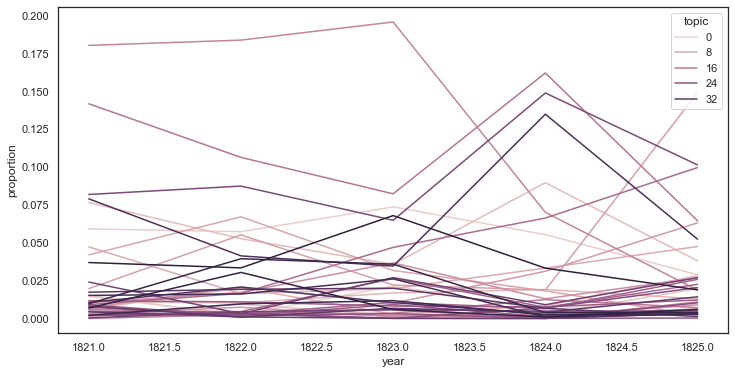

In [9]:
%%time

trends = pd.melt(dtm, id_vars = ['file', 'entry', 'date', 'subject'],
                 var_name = 'topic', value_name = 'proportion')

trends = trends \
    .assign( year = pd.to_datetime(trends['date']).dt.year ) \
    .groupby(['year', 'topic'])['proportion'].mean() \
    .reset_index()

# Plot graph.
sns.set(rc = {"figure.figsize": (12, 6)})
sns.set_style("white")

ax = sns.lineplot(data = trends, x = 'year', y = 'proportion', hue = 'topic')

#### Correlations

CPU times: user 765 ms, sys: 9.67 ms, total: 775 ms
Wall time: 783 ms


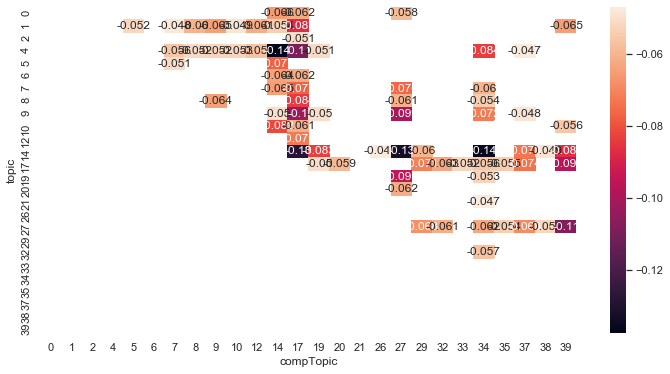

In [10]:
%%time

# Measure correlations.
# From Alollz (StackOverflow)
dtm_corr = pd.DataFrame()
dtm_pValues = pd.DataFrame()

# For each column in topics (columns 4 through end), measure correlation with other columns.
for x in dtm.iloc[:, 4:].columns:
    for y in dtm.iloc[:, 4:].columns:
        corr = stats.pearsonr(dtm[x], dtm[y])
        
#         Append results to dataframe at x-row, y-column.
        dtm_corr.loc[x, y] = corr[0]
        dtm_pValues.loc[x, y] = corr[1]

# Gather p-values into long dataframe and filter out insignificant results.
dtm_pValues['topic'] = dtm_pValues.index

dtm_pValues = pd.melt(dtm_pValues,
                      id_vars = ['topic'], var_name = 'compTopic')

dtm_pValues = dtm_pValues \
    .query('(topic != compTopic) & (value <= 0.025)')

# Gather correlations into dataframe and filter out insignificant results.
dtm_corr['topic'] = dtm_corr.index

dtm_corr = pd.melt(dtm_corr,
                   id_vars = ['topic'], var_name = 'compTopic', value_name = 'corr') \
    .query('(topic != compTopic)')

# Merge correlations and p-values in such a way to remove insignificant correlations/values.
dtm_corr = pd.merge(dtm_corr, dtm_pValues, on = ['topic', 'compTopic'], how = 'right')

# Convert dtm_corr dataframe to matrix for heatmap now that only the significant results remain.
dtm_corr = dtm_corr.pivot(index = 'topic', columns = 'compTopic', values = 'corr')

# Return upper triangle correlations.
# Lower triangle is redundant in symmetrical matrices.
dtm_corr = dtm_corr.where(np.triu(np.ones(dtm_corr.shape)).astype(np.bool))

# Plot heatmap of correlations.
ax = sns.heatmap(dtm_corr, annot = True)

## Save Data

In [11]:
%%time

# Save doc-topic matrix.
dtm.to_csv(abs_dir + 'Output/TopicModels/jqa_topics-40.csv', sep = ',', index = False)

CPU times: user 144 ms, sys: 6.26 ms, total: 150 ms
Wall time: 150 ms


In [12]:
%%time


# Save topic-word matrix.
twm = pd.DataFrame(lda.components_)

twm.columns = vectorizer.get_feature_names()

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


topic_keywords = show_topics(vectorizer, lda, n_words=7) 

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

df_topic_keywords

CPU times: user 24 ms, sys: 1.29 ms, total: 25.3 ms
Wall time: 24.8 ms


In [13]:
%%time

# Save keywords.
df_topic_keywords.to_csv(abs_dir + 'Output/TopicModels/jqa_topics-40-keywords.csv', sep = ',', index = False)

# Save correlations.
dtm_corr.to_csv(abs_dir + 'Output/TopicModels/jqa_topics-40_corr.csv', sep = ',', index = False)

CPU times: user 2.44 ms, sys: 1.5 ms, total: 3.94 ms
Wall time: 3.11 ms
